In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#!unzip '/content/drive/My Drive/arabic-sentiment-analysis-dataset-ss2030-dataset.zip' -d /content/

# Import Libraries

In [ ]:
import pandas as pd 
import string 
import nltk
from nltk.stem.isri import ISRIStemmer
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
from tensorflow.python.keras import models

# Read DataSet

In [ ]:
Neg_Tweets = pd.read_csv('/content/NegTrain.txt', encoding='windows-1256',names=[ "tweets"]) # dataframe 
Neg_Tweets['labels'] = 'Neg' #assign labels to every row
Neg_Tweets.head()

,tweets,labels
0,امتلأت هذه الفترة بالكثير من الجراح والطعنات ا...,Neg
1,سامي الجابر غبي اثبت نفسك انك ممتاز وانك كفاءة...,Neg
2,لاتستطيع تقييم العمل بشكل مطلق ونهائي . . . لو...,Neg
3,تبغى تتابعه بكيفك هذا رايك انا المسلسل ماعجبني...,Neg
4,التشقير بالليزر ضعيف ولايخفف الشعر ولايوجد حل ...,Neg


In [ ]:
Pos_Tweets = pd.read_csv('/content/PosTrain.txt', encoding='windows-1256',names=[ "tweets"])
Pos_Tweets['labels'] = 'Pos'
Pos_Tweets.head()

,tweets,labels
0,لا تجد قوما أشد سعادة في الدنيا ولا أوسع صدورا...,Pos
1,! رسايلك صوتك سوالفك طاريك والله إنها للقلب مص...,Pos
2,سعادة الآخرين لن تؤخذ من سعادتك,Pos
3,المعصية لها توبة,Pos
4,مساء السعادة,Pos


In [ ]:
Test_Pos_Tweets = pd.read_csv('/content/PosTest.txt', encoding='windows-1256',names=[ "tweets"])
Test_Pos_Tweets['labels'] = 'Pos'

In [ ]:
Test_Neg_Tweets = pd.read_csv('/content/NegTest.txt', encoding='windows-1256',names=[ "tweets"])
Test_Neg_Tweets['labels'] = 'Neg'

In [ ]:
new_data=pd.read_csv('/content/Arabic Sentiment Analysis Dataset - SS2030.csv')
new_data.columns=['tweets','labels']
new_data.head()

,tweets,labels
0,حقوق المرأة 💚💚💚 https://t.co/Mzf90Ta5g1,1
1,RT @___IHAVENOIDEA: حقوق المرأة في الإسلام. ht...,1
2,RT @saud_talep: Retweeted لجنة التنمية بشبرا (...,1
3,RT @MojKsa: حقوق المرأة التي تضمنها لها وزارة ...,1
4,RT @abm112211: ولي امر الزوجة او ولي الزوجة او...,1


In [ ]:
new_data.labels=new_data.labels.astype('int64')

In [ ]:
new_data['labels']= new_data['labels'].map( {1:'Pos', 0:'Neg'} )

# Combine All Test And Train Set

In [ ]:
tweets=pd.concat([Pos_Tweets,Neg_Tweets,Test_Neg_Tweets,Test_Pos_Tweets,new_data],axis=0, ignore_index=True,sort=False )

# Exploratory Data Analysis
Let's check out some of the stats with some plots and the built-in methods in pandas!



In [ ]:
tweets.describe()

,tweets,labels
count,15359,15364
unique,15249,2
top,ممتاز,Neg
freq,11,7971


Let's use groupby to use describe by label, this way we can begin to think about the features that separate Pos and Neg!

In [ ]:
tweets.groupby('labels').describe()

tweets                    
        count unique     top freq
labels                           
Neg      7969   7923  للأسف     8
Pos      7390   7331  ممتاز    11

# Text Pre-processing

### Check Null Values

In [ ]:
tweets.isnull().sum()

tweets    5
labels    0
dtype: int64

In [ ]:
tweets.dropna(inplace=True) #drop null rows
tweets.isnull().sum()

tweets    0
labels    0
dtype: int64

### Check Duplicate Recode

In [ ]:
tweets.tweets.duplicated().sum()

110

In [ ]:
tweets.loc[tweets.tweets.duplicated(),:] #duplicate recode

,tweets,labels
283,مساء الخير,Pos
345,مساء السعادة,Pos
615,رائع,Pos
822,ممتاز,Pos
843,ممتاز,Pos
...,...,...
13548,@seen_180 انا قدها وانا بصراحه مع تعدد الزوجات,Pos
13560,RT @bbahth2: #تعدد_الزوجات سبب لنشر العفاف وإع...,Pos
13644,@Akhbaar24 حسبي الله ونعم الوكيل عليهم ودعمهم ...,Neg
13647,RT @SAUD_SAIFALNASR: #ابشركم_حنا_بخير تكاليف ا...,Neg


In [ ]:
tweets.drop_duplicates(subset=['tweets'],keep='first',inplace=True) # drop duplicates and kepp one of them

In [ ]:
tweets.tweets.duplicated().sum()

0

## Clean Text
Let's create a function that will process the string in the tweets column, then we can just use apply() in pandas do process all the text in the DataFrame.

In [ ]:
# Arabic diacritics
arabic_punct = ''' ` ÷ × ؛ < > _ ( ) * & ^ % ] [ ـ ، / : " ? ؟ . , ' { } ~ ¦ + | !  ”  …  “ –   ـ  '''
arabic_diacritics = '''  َ     ُ       ِ      ّ       ً      ٌ       ٍ      ْ     '''
english_punctuations = string.punctuation

arabic_punct = arabic_punct.split()
arabic_diacritics = arabic_diacritics.split()

# Arabic punctuations and dicritis 
punctuations = str(arabic_punct  + arabic_diacritics)
punctuations=punctuations+english_punctuations
# Arabic stopwords
asw = open('/content//stop_words.txt', encoding="utf8").read()

arabicStopWords =  set(asw.split())

In [ ]:
# remove arabic diacritics
def remove_diacritics(text):
	arstemmer = ISRIStemmer()
	result = arstemmer.norm(text, num=1) #  remove diacritics which representing Arabic short vowels
	return result

In [ ]:
regex = re.compile('[%s]' % re.escape(punctuations))
# remove punctcutions
def remove_punct(word):
  return regex.sub(' ', word)
  #return word.translate(str.maketrans('','',punctuations))

In [ ]:
def reove_eng_word(word):
    text=re.sub(r'[0-9]', '' , word)
    return re.sub(r'[a-z]+', '' , text)

In [ ]:
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
def remove_emojies(string):
    return emoji_pattern.sub(r'', string)

In [ ]:
def process_text(text, removePunct=True, removeSW=False, removeNum=True,removeEng=True,remove_emoji=True):
	'''
	1. remove arabic diacritics
	2. remove punctcutions
	3. remove stopwords if removeSW=True
	4. remove numbers if removeNum=True
	'''
	text = remove_diacritics(text)  # remove arabic diacritics
	word_list = nltk.tokenize.wordpunct_tokenize(text.lower())
	if removePunct:
		word_list = [ w for w in word_list if not w in punctuations ]
		word_list = [ remove_punct(w) for w in word_list ]

	if removeSW: word_list = [ w for w in word_list if not w in arabicStopWords ]
	if removeEng: 
		word_list  = [ reove_eng_word(w) for w in word_list ]
	if remove_emoji:
		word_list  = [ remove_emojies(w) for w in word_list ]
	#if removeNum: word_list = [ w for w in word_list if not w.isdigit() ]
	word_list = [ w for w in word_list if w] # remove empty words
	#return ' '.join(word_list)
	return (re.sub(' +', ' ', ' '.join(word_list))).strip() # remove spaces more then 1 .

In [ ]:
tweets['tweets'][1]

'! رسايلك صوتك سوالفك طاريك والله إنها للقلب مصدر سعادة ء ء'

In [ ]:
process_text(tweets['tweets'][1])

'رسايلك صوتك سوالفك طاريك والله إنها للقلب مصدر سعادة ء ء'

In [ ]:
new_data['tweets'][1]

'RT @___IHAVENOIDEA: حقوق المرأة في الإسلام. https://t.co/ps3qNw1CbB'

In [ ]:
process_text(new_data['tweets'][1])

'حقوق المرأة في الإسلام'

In [ ]:
new_data['tweets'][0]

'حقوق المرأة 💚💚💚 https://t.co/Mzf90Ta5g1'

In [ ]:
process_text(new_data['tweets'][0])

'حقوق المرأة'

Apply this function now to all tweets

In [ ]:
tweets['tweets'] = tweets['tweets'].apply(process_text) # apply it to all tweets

In [ ]:
tweets.head(5)

,tweets,labels
0,لا تجد قوما أشد سعادة في الدنيا ولا أوسع صدورا...,Pos
1,رسايلك صوتك سوالفك طاريك والله إنها للقلب مصدر...,Pos
2,سعادة الآخرين لن تؤخذ من سعادتك,Pos
3,المعصية لها توبة,Pos
4,مساء السعادة,Pos


As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering). The better your domain knowledge on the data, the better your ability to engineer more features from it. I encourage you to read up on the topic!

Let's make a new column to detect how long the text messages are:

In [ ]:
tweets['length'] = tweets['tweets'].str.len() #check Leanth of Each tweet
tweets.head()

,tweets,labels,length
0,لا تجد قوما أشد سعادة في الدنيا ولا أوسع صدورا...,Pos,131
1,رسايلك صوتك سوالفك طاريك والله إنها للقلب مصدر...,Pos,56
2,سعادة الآخرين لن تؤخذ من سعادتك,Pos,31
3,المعصية لها توبة,Pos,16
4,مساء السعادة,Pos,12


In [ ]:
tweets.length.describe()

count    15249.000000
mean        87.172601
std         59.223386
min          0.000000
25%         42.000000
50%         76.000000
75%        118.000000
max        280.000000
Name: length, dtype: float64

Maximum tweet leanth is 185.

In [ ]:
tweets = tweets.sample(frac=1,random_state=30).reset_index(drop=True) #shuffle data frame

# Data Visualization
Let's visualize this! Let's do the imports:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


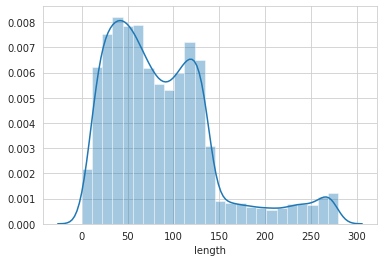

In [ ]:
sns.set_style('whitegrid')
sns.distplot(tweets['length'],bins=25)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9998818438>,
      dtype=object)

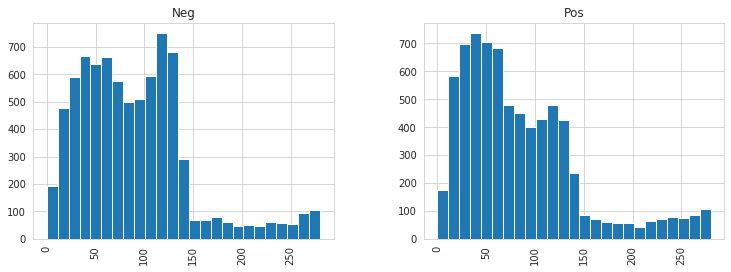

In [ ]:
tweets.hist(column='length', by='labels', bins=25,figsize=(12,4))

# Prepare Data

In [ ]:

from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalMaxPool1D

### Encoding
Encode class data to numeric format

In [ ]:
tweets['labels']= tweets['labels'].map( {'Pos':1, 'Neg': 0} ).astype(int)

# Train_Test_Split

We will convert our data in three parts, training,validation and testing. We train our model on traing and tune on validation and then test it on testing data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    tweets['tweets'], tweets['labels'], random_state=0,stratify=tweets['labels'],test_size=0.30,shuffle=True)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, random_state=0,stratify=y_train,test_size=0.10,shuffle=True)

Before our data can be fed to a model, it needs to be transformed to a format the model can understand. This means that we will need to convert the texts into numerical vectors.

In [ ]:
# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000
# Limit on the length of text sequences. Sequences longer than this will be truncated.
MAX_SEQUENCE_LENGTH = 200

def sequence_vectorize(train_texts, val_texts):
    """
    Vectorizes texts as sequence vectors.
    1 text = 1 sequence vector with fixed length.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index,tokenizer,max_length

# Build, Train, and Evaluate Your Model

In [ ]:
def _get_last_layer_units_and_activation(num_classes):
    """
    Gets the number of output neuron  and 
    activation function for the last network layer.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation
    

### Model Architecture


In [ ]:
def sequence_model(
                 embedding_dim,
                 dropout_rate,
                 input_shape,
                 num_classes,
                 num_features
                 ):
    """
    Creates an instance of a sequence_model

    # Arguments
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
    # Returns
        A sequence model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes) #get op_unit and output activation function

    #Model Architecture
    model = models.Sequential()
    model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))
    model.add(GlobalMaxPool1D())
    model.add(Dense(embedding_dim, activation = 'relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, op_activation))
    return model

### Number Of classes

In [ ]:
def get_num_classes(labels):
    """
    Gets the total number of classes
    # Arguments
        labels: label values
    # Returns
             total number of classes.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes

## Data Generator
genrate data in term of baches

In [ ]:
def _data_generator(x, y, num_features, batch_size):
    """
    Generates batches of vectorized texts for training/validation

    # Arguments
        x: feature matrix.
        y:  labels.
        num_features:  number of features.
        batch_size: number of samples per batch.
    # Returns
        Yields feature and label data in batches.
    """
    num_samples = x.shape[0]
    num_batches = num_samples // batch_size
    if num_samples % batch_size:
        num_batches += 1

    while 1:
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            if end_idx > num_samples:
                end_idx = num_samples
            x_batch = x[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]
            yield x_batch, y_batch

## Train Model

In [ ]:
def batch_train_sequence_model(data,
                               learning_rate=1e-3,
                               epochs=70,
                               batch_size=1000,
                               dropout_rate=0.2,
                               embedding_dim=32,
                               ):
    """Trains sequence model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: learning rate for training model.
        epochs: number of epochs.
        batch_size:  number of samples per batch.
        dropout_rate: percentage of input to drop at Dropout layers.
        embedding_dim: dimension of the embedding vectors.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val, word_index,tokenizer,max_length = sequence_vectorize(
            train_texts, val_texts)

    # Number of features will be the embedding input dimension. Add 1 for the
    # reserved index 0 for padding
    num_features = min(len(word_index) + 1, TOP_K)

    # Create model instance.
    model = sequence_model( embedding_dim=embedding_dim,
                                     dropout_rate=dropout_rate,
                                     input_shape=x_train.shape[1:],
                                     num_classes=num_classes,
                                     num_features=num_features)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy' # if number of classes is two then use this loss function else
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Create training and validation generators.
    training_generator = _data_generator(
        x_train, train_labels, num_features, batch_size)
    validation_generator = _data_generator(
        x_val, val_labels, num_features, batch_size)

    # Get number of training steps. This indicated the number of steps it takes
    # to cover all samples in one epoch.
    steps_per_epoch = x_train.shape[0] // batch_size
    if x_train.shape[0] % batch_size:
        steps_per_epoch += 1

    # Get number of validation steps.
    validation_steps = x_val.shape[0] // batch_size
    if x_val.shape[0] % batch_size:
        validation_steps += 1

    # Train and validate model.
    history = model.fit_generator(
            generator=training_generator,
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_generator,
            validation_steps=validation_steps,
            callbacks=callbacks,
            epochs=epochs,
            verbose=2)  # Logs once per epoch.

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('model.h5')
    return history['val_acc'][-1], history['val_loss'][-1],tokenizer,max_length

In [ ]:
data=((X_train, np.array(y_train)),(X_val, np.array(y_val)))

In [ ]:
val_acc,val_loss,tokenizer,max_length=batch_train_sequence_model(data)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/70
Epoch 1/70
10/10 - 1s - loss: 0.6948 - acc: 0.4853 - val_loss: 0.6901 - val_acc: 0.5112
Epoch 2/70
Epoch 1/70
10/10 - 0s - loss: 0.6864 - acc: 0.6670 - val_loss: 0.6846 - val_acc: 0.7257
Epoch 3/70
Epoch 1/70
10/10 - 0s - loss: 0.6783 - acc: 0.7793 - val_loss: 0.6762 - val_acc: 0.7734
Epoch 4/70
Epoch 1/70
10/10 - 0s - loss: 0.6647 - acc: 0.8409 - val_loss: 0.6624 - val_acc: 0.8043
Epoch 5/70
Epoch 1/70
10/10 - 0s - loss: 0.6438 - acc: 0.8740 - val_loss: 0.6420 - val_acc: 0.8212
Epoch 6/70
Epoch 1/70
10/10 - 0s - loss: 0.6133 - acc: 0.8878 - val_loss: 0.6142 - val_acc: 0.8315
Epoch 7/70
Epoch 1/70
10/10 - 0s - loss: 0.5735 - acc: 0.8925 - val_loss: 0.5788 - val_acc: 0.8371
Epoch 8/70
Epo

## Testing
converting test data into sequence vector

In [ ]:
X_test.head()

3620                الله الله توظيف التخصص شعريا شعور رائع
7464                      محتاجة تفكير إيجابي و تشجيع كتير
10457    ذكرت ارقام الوظائف المباشرة وغير المباشرة في م...
6653     سعوديات نطلب اسقاط الولايه ٥ نوفمبر ٢٠١٨م من ا...
1165     برت من الجيد و للاسف اني شاهدته قدام عيوني ينج...
Name: tweets, dtype: object

In [ ]:
x_test = tokenizer.texts_to_sequences(X_test)
x_test = sequence.pad_sequences(x_test, maxlen=max_length)
num_features = min(len(tokenizer.word_index) + 1, TOP_K)

Convert X_test in baches

In [ ]:
testing_generator = _data_generator( x_test, y_test,num_features,1000)
steps_per_epoch = x_test.shape[0] // 1000
if x_test.shape[0] % 1000:
  steps_per_epoch += 1

Load Model

In [ ]:
# load model
model = tf.keras.models.load_model('/content/model.h5')
# summarize model.
model.summary()
# evaluate the model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 58, 32)            640000    
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 641,

Get the Score on Testing

In [ ]:
score = model.evaluate_generator(generator=testing_generator, steps=steps_per_epoch,verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

5/5 - 0s - loss: 0.2705 - acc: 0.8776
acc: 87.76%


Now check Our model on السعودية examples.

First collect examples of السعودية

In [ ]:
Saudi_Arabia_index = X_test.str.contains('السعودية')
Saudi_Arabia=X_test[Saudi_Arabia_index]
labels_Saudia=y_test[Saudi_Arabia_index]
Saudia=pd.concat([Saudi_Arabia,labels_Saudia],axis=1, ignore_index=True,sort=False )

In [ ]:
Saudia.index=np.arange(0, len(Saudia))
Saudia.columns=['tweets','labels']

In [ ]:
Saudia.head()

,tweets,labels
0,السعودية الجديدة وضعت لها خطط لتحقيق أهداف محد...,1
1,سعوديات نطلب اسقاط الولايه الولاية على النساء ...,1
2,معليك منها ياحامد في بعض العينات في السعودية ي...,1
3,كل الشكر للأنظمة الجديدة و القوانين الصارمة لأ...,1
4,لا يرجد عدل في السعودية ولا توجد شريعة كذلك هذ...,0


In [ ]:
Saudia.dtypes

tweets    object
labels     int64
dtype: object

Count Number of Exaples

In [ ]:
Saudia.count()

tweets    108
labels    108
dtype: int64

Convert Data into Vectors

In [ ]:
x_test = tokenizer.texts_to_sequences(Saudia.tweets)
x_test = sequence.pad_sequences(x_test, maxlen=max_length)

In [ ]:
len(x_test)

108

Lets Check How Many We predict Correct and Wrong with Confusion Matrix

In [ ]:
def getConfusionMatrix(y_hat,y_test):
    TN = len([1 for ind in range(len(y_test)) if y_test.iloc[ind]==0 and y_hat.iloc[ind]==0])
    FP = len([1 for ind in range(len(y_test)) if y_test.iloc[ind]==0 and y_hat.iloc[ind]==1])
    FN = len([1 for ind in range(len(y_test)) if y_test.iloc[ind]==1 and y_hat.iloc[ind]==0])
    TP = len([1 for ind in range(len(y_test)) if y_test.iloc[ind]==1 and y_hat.iloc[ind]==1])
    return TN,FP,FN,TP

In [ ]:
y_hat = model.predict_classes(x_test)

In [ ]:
numTN,numFP,numFN,numTP = getConfusionMatrix(pd.Series(y_hat.reshape(-1)),Saudia.labels)
print ('confusion matrix:')
print ('\tpred-0\tpred-1')
print ('is-0\tTN=%d\tFP=%d' %(numTN,numFP))
print ('is-1\tFN=%d\tTP=%d' %(numFN,numTP))

confusion matrix:
	pred-0	pred-1
is-0	TN=34	FP=11
is-1	FN=5	TP=58


It means we predict All negative tweets correctly and 2 positive tweets as negative . Our concentration was only Negative which We dont want to predict Wrong. It means We get best Model.

## ROC Curve

In [ ]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Saudia.labels, y_hat.ravel())

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

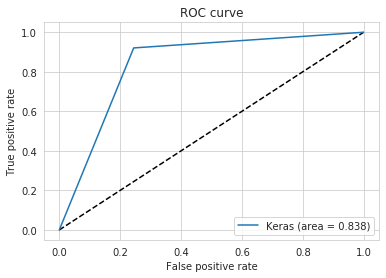

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Evaluate precision

In [ ]:
def getPrecision(y_hat,y_test):
    TN,FP,FN,TP=getConfusionMatrix(y_hat,y_test)
    return TP/(TP+FP)

In [ ]:
getPrecision(pd.Series(y_hat.reshape(-1)),Saudia.labels)

0.8405797101449275

Evaluate Recall

In [ ]:
def getRecall(y_hat,y_test):
    TN,FP,FN,TP=getConfusionMatrix(y_hat,y_test)
    return TP/(TP+FN)

In [ ]:
getRecall(pd.Series(y_hat.reshape(-1)),Saudia.labels)

0.9206349206349206

In [ ]:
yhat=pd.Series(y_hat.reshape(-1))
#checking first five
for i in range(1,6): 
  print(Saudia.tweets[i]," Predict:",yhat[i])
  

سعوديات نطلب اسقاط الولايه الولاية على النساء وسلب ارادتهن استعباد للبشر بصك شرعي للولي يتصرف فيها كيف يشاء وين المنطق من الولاية الصهيونية اللي فرضت على المرأة السعودية  Predict: 1
معليك منها ياحامد في بعض العينات في السعودية يعتبرون ان المرأة مالها حقوق وإن دافعت عن حقها او طالبت به فهي غير شريفة والمشكلة انهم مايتقبلوا اي سبب منطقي او عقلاني هم كذا نفس قوم قريش زمان يتبعون شي و  Predict: 0
كل الشكر للأنظمة الجديدة و القوانين الصارمة لأمن الطرق و السلامة أخوي صار يربط حزام الأمان من تلقاء نفسه و الوالدة كذلك كلنا مع السعودية ايد واحدة  Predict: 1
لا يرجد عدل في السعودية ولا توجد شريعة كذلك هذه الكذبة لم يعد يصدقها الا جاهل مئات المعتقلين بلا تهم او محاكمات حفلات ومجون هيئة الترفيه وانفتاح غير مبرر بنوك ربوية وغيره وغيره  Predict: 0
عالميا يساوي الاستغلال الجنسي مليار دولار سنويا اليوم العالمي للمرأة السعودية مصر الامارات  Predict: 0
